# Uncertainty Quantification for Subsurface Modeling

This is the Jupyter Notebook tutorial (Python) for runing Monte Carlo modeling with SGeMS. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.covariance import MinCovDet as MCD
from scipy import stats
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize']=15
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
plt.rcParams['axes.labelpad'] = 5

# Example Project

Here we use a synthetic dataset, build using real seismic data, as example (see the figure below). 

Goal: We need to simulate facies, porosity, and permeability, thus there will be spatial uncertainty.

We will use a geostatistical approach (SGSim) to model the spatial uncertainty. Here, we use the AR2GeMS (a Stanford geostatistical modeling software version) software to implement this idea. 

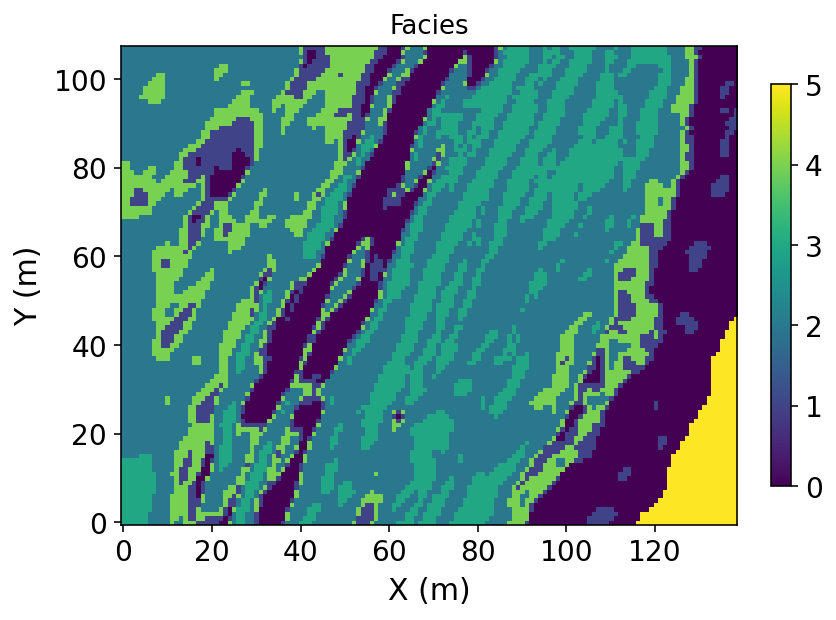

In [15]:
TI_facies = pd.read_csv('2D_section_XY.csv')['Facies'].values.reshape(108,139)
plt.figure(figsize=(6,5))
TI_HMM = plt.imshow(TI_facies, 
           #vmax = TI_facies[np.isfinite(TI_facies)].max()*0.85, 
           #extent=[0, 139,0, 108 ],
           origin='lower',
           interpolation='nearest')
plt.colorbar(fraction=0.03)
plt.title('Facies', fontsize=13)
plt.xlabel('X (m)'), plt.ylabel('Y (m)')
plt.show()
fig = TI_HMM.get_figure()
fig.savefig("images/TI_HMM.png") 

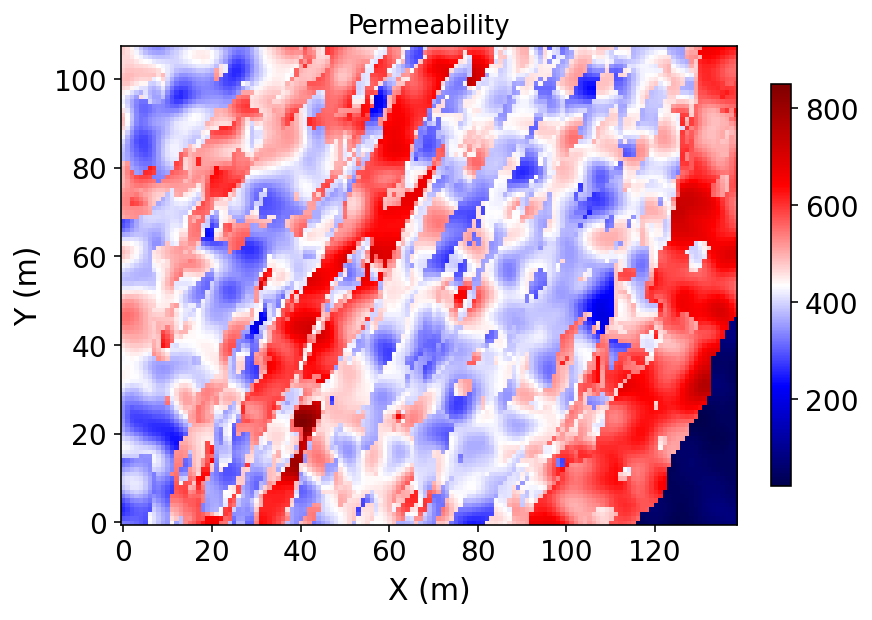

In [19]:
TI_Permeability = pd.read_csv('2D_section_XY.csv')['Permeability'].values.reshape(108,139)
plt.figure(figsize=(6,5))
True_Permeability = plt.imshow(TI_Permeability, 
           #vmax = TI_facies[np.isfinite(TI_facies)].max()*0.85, 
           #extent=[0, 139,0, 108 ],
           cmap = 'seismic',
           origin='lower',
           interpolation='nearest')
plt.colorbar(fraction=0.03)
plt.title('Permeability', fontsize=13)
plt.xlabel('X (m)'), plt.ylabel('Y (m)')
plt.show()
fig = True_Permeability.get_figure()
fig.savefig("images/True_Permeability.png") 

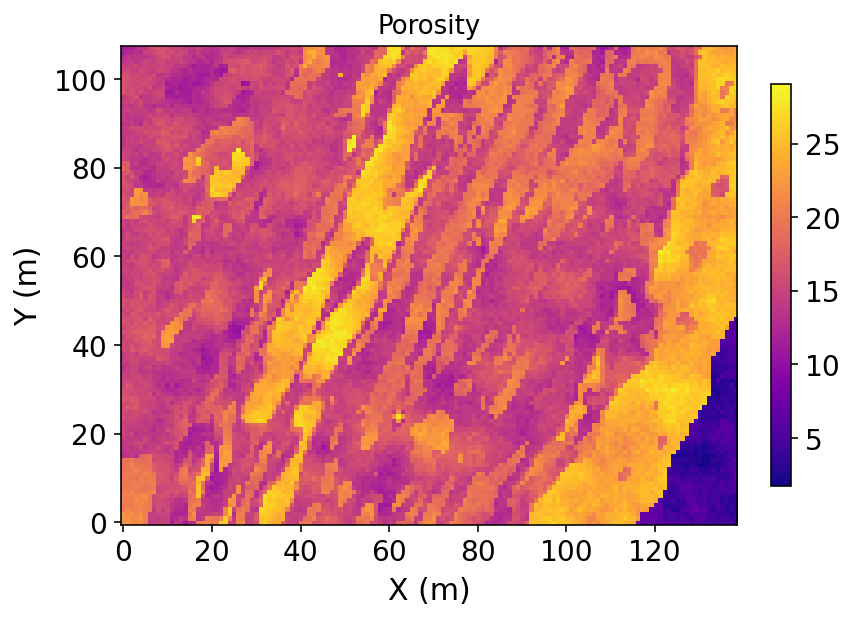

In [70]:
TI_Porosity = pd.read_csv('2D_section_XY.csv')['Porosity'].values.reshape(108,139)
plt.figure(figsize=(6,5))
True_Porosity = plt.imshow(TI_Porosity, 
           #vmax = TI_facies[np.isfinite(TI_facies)].max()*0.85, 
           #extent=[0, 139,0, 108 ],
           cmap = 'plasma',
           origin='lower',
           interpolation='nearest')
plt.colorbar(fraction=0.03)
plt.title('Porosity', fontsize=13)
plt.xlabel('X (m)'), plt.ylabel('Y (m)')
plt.show()
fig = True_Porosity.get_figure()
fig.savefig("images/True_Porosity.png") 

# Step 1. Define all categories present of your model

When using SGSim to model the spatial uncertainty, the global parameters are mainly from variogram model, mean, variance. 

In [2]:
# define number of MC samples, eg. here I set n_smpls=10
n_smpls = 100
n_category = 6

In [4]:
with open('Generate_regions.py', 'w') as f:
    f.write('import sgems'+"\n")
    
    for i in range(n_smpls):
        for j in range(n_category):
            f.write('sgems.execute("SetRegionFromCategoricalPropertyIf  2D_Section_XY::snesim_facies__real'+str(i)+'_Category_'+str(j)+'::snesim_facies__real'+str(i)+'::Category '+str(j)+'")'+ "\n")

# Step 2. Define global parameter uncertainty and run Monte Carlo of the global parameters

When using SGSim to model the spatial uncertainty, the global parameters are mainly from variogram model, mean, variance. 

Let's assume that we roughly know the kind of porosity and permeability of each facies.

Facies		Perm		Por (0.1 NE)		Anis
0			high 		high				Isot Gauss
1			interm		interm				Isot Gauss
2			low			low					Isot Gauss
3			low			interm				Isot Gauss
4			interm		low					Isot Gauss
5			ext low		ext low				Isot Gauss

In [5]:
# define global uncertainty parameters. 

#Variogram model uncertainty. 

## define uncertainty of variogram azimuth 
azimuth = np.random.uniform(0, 180, n_smpls)
## define uncertainty of variogram range in major direction
range_maj = np.random.uniform(100, 10000, n_smpls)
## define uncertainty of variogram range in minor direction
range_interm = np.random.uniform(100, 5000, n_smpls)
## define uncertainty of nugget
nugget = np.random.uniform(0.0001, 0.2, n_smpls)
## Facies		Perm		Por (0.1 NE)		Anis
## 0			high 		high				Isot Gauss
## 1			interm		interm				Isot Gauss
## 2			low			low					Isot Gauss
## 3			low			interm				Isot Gauss
## 4			interm		low					Isot Gauss
## 5			ext low		ext low				Isot Gauss
perm_distribution_type = ['dist_high_perm','dist_interm_perm','dist_low_perm','dist_low_perm','dist_interm_perm','dist_ext_low_perm']
por_distribution_type = ['dist_high_por','dist_interm_por','dist_low_por','dist_interm_por','dist_low_por','dist_ext_low_por']

# define results export directory. Set to your own directory.
export_dir = 'C:/Users/Jonas Kloeckner/Desktop/PhD/Stanford_Classes/Quantifying_Uncertainty_in_Subsurface_Systems/Project/sgsim_results/'

n_smpls = 5
n_category = 5

for i in range(n_smpls):
    for j in range(n_category):
        if j == 0:
            dist = 'dist_high_perm'
            print (i,j,dist)
        elif j == 1:
            dist = 'dist_interm_perm'
            print (i,j,dist)
        elif j == 2:
            dist = 'dist_low_perm'
            print (i,j,dist)
        elif j == 3:
            dist = 'dist_low_perm'
            print (i,j,dist)
        elif j == 4:
            dist = 'dist_interm_perm'
            print (i,j,dist)
        else:
            dist = 'dist_ext_low_perm'
            print (i,j,dist)


# Step 3. Export AR2GeMS command lines for running SGSim with MC global parameters - Permeability

In [83]:
with open('MC_sgems_sgsim_perm.py', 'w') as f:
    f.write('import sgems'+"\n")
    
    for i in range(n_smpls):
        for j in range(n_category):
            if j == 0:
                dist = 'dist_high_perm'
                f.write('sgems.execute(\'RunGeostatAlgorithm  sgsim::/GeostatParamUtils/XML::<parameters>  <algorithm name="sgsim" />     \
            <Simulation_seed type="constant" seed="'+str(str(np.random.randint(1000000)))+'"/>  \
            <Path type="random"><Seed type="constant" seed="1117111"/></Path>  \
            <Nb_processors  value="-2"  />    <Covariance_input  structures_count="2" >    <Structure_1 type="Covariance">  \
            <Two_point_model  contribution="'+str(nugget[i])+'"  type="Nugget Covariance"   >    </Two_point_model>    </Structure_1>    \
            <Structure_2 type="Covariance">  <Two_point_model  contribution="1"  type="Spherical Covariance"   >      \
            <ranges range1="'+str(range_maj[i])+'"  range2="'+str(range_interm[i])+'"  range3="100"   />      \
            <angles azimuth="'+str(azimuth[i])+'"  dip="0"  rake="0"   />    \
            </Two_point_model>    </Structure_2>  </Covariance_input>    <Assign_Hard_Data  value="0"  />     \
            <Hard_Data  grid=""   property=""   region=""  />     <Use_Target_Histogram  value="1"  />     \
            <Export_nscore  value="0"  />     <Use_break_tie_index  value="0"  />     \
            <nonParamCdf  ref_in_distribution ="1"  ref_on_file ="0" ref_on_grid ="0" break_ties_indices ="0" \
            distribution ="'+str(dist)+'"  ></nonParamCdf>    <Grid_Name value="2D_Section_XY" \
            region="snesim_facies__real'+str(i)+'_Category_'+str(j)+'"  />     \
            <Property_Name value="perm_snesim_facies__real'+str(i)+'" reuse_property="0" />  <Nb_Realizations  value="1" />     \
            <Use_LVM  value="0"  />     <Max_Conditioning_Data  value="12" />     \
            <Max_Conditioning_Simul_Data  value="12" />     <Search_Ellipsoid  value="1000 1000 1  0 0 0" />    \
            <AdvancedSearch  use_advanced_search="0"></AdvancedSearch>  </parameters>   \') '+ "\n")
            elif j == 1:
                dist = 'dist_interm_perm'
                f.write('sgems.execute(\'RunGeostatAlgorithm  sgsim::/GeostatParamUtils/XML::<parameters>  <algorithm name="sgsim" />     \
            <Simulation_seed type="constant" seed="'+str(str(np.random.randint(1000000)))+'"/>  \
            <Path type="random"><Seed type="constant" seed="1117111"/></Path>  \
            <Nb_processors  value="-2"  />    <Covariance_input  structures_count="2" >    <Structure_1 type="Covariance">  \
            <Two_point_model  contribution="'+str(nugget[i])+'"  type="Nugget Covariance"   >    </Two_point_model>    </Structure_1>    \
            <Structure_2 type="Covariance">  <Two_point_model  contribution="1"  type="Spherical Covariance"   >      \
            <ranges range1="'+str(range_maj[i])+'"  range2="'+str(range_interm[i])+'"  range3="100"   />      \
            <angles azimuth="'+str(azimuth[i])+'"  dip="0"  rake="0"   />    \
            </Two_point_model>    </Structure_2>  </Covariance_input>    <Assign_Hard_Data  value="0"  />     \
            <Hard_Data  grid=""   property=""   region=""  />     <Use_Target_Histogram  value="1"  />     \
            <Export_nscore  value="0"  />     <Use_break_tie_index  value="0"  />     \
            <nonParamCdf  ref_in_distribution ="1"  ref_on_file ="0" ref_on_grid ="0" break_ties_indices ="0" \
            distribution ="'+str(dist)+'"  ></nonParamCdf>    <Grid_Name value="2D_Section_XY" \
            region="snesim_facies__real'+str(i)+'_Category_'+str(j)+'"  />     \
            <Property_Name value="perm_snesim_facies__real'+str(i)+'" reuse_property="0" />  <Nb_Realizations  value="1" />     \
            <Use_LVM  value="0"  />     <Max_Conditioning_Data  value="12" />     \
            <Max_Conditioning_Simul_Data  value="12" />     <Search_Ellipsoid  value="1000 1000 1  0 0 0" />    \
            <AdvancedSearch  use_advanced_search="0"></AdvancedSearch>  </parameters>   \') '+ "\n")
            elif j == 2:
                dist = 'dist_low_perm'
                f.write('sgems.execute(\'RunGeostatAlgorithm  sgsim::/GeostatParamUtils/XML::<parameters>  <algorithm name="sgsim" />     \
            <Simulation_seed type="constant" seed="'+str(str(np.random.randint(1000000)))+'"/>  \
            <Path type="random"><Seed type="constant" seed="1117111"/></Path>  \
            <Nb_processors  value="-2"  />    <Covariance_input  structures_count="2" >    <Structure_1 type="Covariance">  \
            <Two_point_model  contribution="'+str(nugget[i])+'"  type="Nugget Covariance"   >    </Two_point_model>    </Structure_1>    \
            <Structure_2 type="Covariance">  <Two_point_model  contribution="1"  type="Spherical Covariance"   >      \
            <ranges range1="'+str(range_maj[i])+'"  range2="'+str(range_interm[i])+'"  range3="100"   />      \
            <angles azimuth="'+str(azimuth[i])+'"  dip="0"  rake="0"   />    \
            </Two_point_model>    </Structure_2>  </Covariance_input>    <Assign_Hard_Data  value="0"  />     \
            <Hard_Data  grid=""   property=""   region=""  />     <Use_Target_Histogram  value="1"  />     \
            <Export_nscore  value="0"  />     <Use_break_tie_index  value="0"  />     \
            <nonParamCdf  ref_in_distribution ="1"  ref_on_file ="0" ref_on_grid ="0" break_ties_indices ="0" \
            distribution ="'+str(dist)+'"  ></nonParamCdf>    <Grid_Name value="2D_Section_XY" \
            region="snesim_facies__real'+str(i)+'_Category_'+str(j)+'"  />     \
            <Property_Name value="perm_snesim_facies__real'+str(i)+'" reuse_property="0" />  <Nb_Realizations  value="1" />     \
            <Use_LVM  value="0"  />     <Max_Conditioning_Data  value="12" />     \
            <Max_Conditioning_Simul_Data  value="12" />     <Search_Ellipsoid  value="1000 1000 1  0 0 0" />    \
            <AdvancedSearch  use_advanced_search="0"></AdvancedSearch>  </parameters>   \') '+ "\n")
            elif j == 3:
                dist = 'dist_low_perm'
                f.write('sgems.execute(\'RunGeostatAlgorithm  sgsim::/GeostatParamUtils/XML::<parameters>  <algorithm name="sgsim" />     \
            <Simulation_seed type="constant" seed="'+str(str(np.random.randint(1000000)))+'"/>  \
            <Path type="random"><Seed type="constant" seed="1117111"/></Path>  \
            <Nb_processors  value="-2"  />    <Covariance_input  structures_count="2" >    <Structure_1 type="Covariance">  \
            <Two_point_model  contribution="'+str(nugget[i])+'"  type="Nugget Covariance"   >    </Two_point_model>    </Structure_1>    \
            <Structure_2 type="Covariance">  <Two_point_model  contribution="1"  type="Spherical Covariance"   >      \
            <ranges range1="'+str(range_maj[i])+'"  range2="'+str(range_interm[i])+'"  range3="100"   />      \
            <angles azimuth="'+str(azimuth[i])+'"  dip="0"  rake="0"   />    \
            </Two_point_model>    </Structure_2>  </Covariance_input>    <Assign_Hard_Data  value="0"  />     \
            <Hard_Data  grid=""   property=""   region=""  />     <Use_Target_Histogram  value="1"  />     \
            <Export_nscore  value="0"  />     <Use_break_tie_index  value="0"  />     \
            <nonParamCdf  ref_in_distribution ="1"  ref_on_file ="0" ref_on_grid ="0" break_ties_indices ="0" \
            distribution ="'+str(dist)+'"  ></nonParamCdf>    <Grid_Name value="2D_Section_XY" \
            region="snesim_facies__real'+str(i)+'_Category_'+str(j)+'"  />     \
            <Property_Name value="perm_snesim_facies__real'+str(i)+'" reuse_property="0" />  <Nb_Realizations  value="1" />     \
            <Use_LVM  value="0"  />     <Max_Conditioning_Data  value="12" />     \
            <Max_Conditioning_Simul_Data  value="12" />     <Search_Ellipsoid  value="1000 1000 1  0 0 0" />    \
            <AdvancedSearch  use_advanced_search="0"></AdvancedSearch>  </parameters>   \') '+ "\n")
            elif j == 4:
                dist = 'dist_interm_perm'
                f.write('sgems.execute(\'RunGeostatAlgorithm  sgsim::/GeostatParamUtils/XML::<parameters>  <algorithm name="sgsim" />     \
            <Simulation_seed type="constant" seed="'+str(str(np.random.randint(1000000)))+'"/>  \
            <Path type="random"><Seed type="constant" seed="1117111"/></Path>  \
            <Nb_processors  value="-2"  />    <Covariance_input  structures_count="2" >    <Structure_1 type="Covariance">  \
            <Two_point_model  contribution="'+str(nugget[i])+'"  type="Nugget Covariance"   >    </Two_point_model>    </Structure_1>    \
            <Structure_2 type="Covariance">  <Two_point_model  contribution="1"  type="Spherical Covariance"   >      \
            <ranges range1="'+str(range_maj[i])+'"  range2="'+str(range_interm[i])+'"  range3="100"   />      \
            <angles azimuth="'+str(azimuth[i])+'"  dip="0"  rake="0"   />    \
            </Two_point_model>    </Structure_2>  </Covariance_input>    <Assign_Hard_Data  value="0"  />     \
            <Hard_Data  grid=""   property=""   region=""  />     <Use_Target_Histogram  value="1"  />     \
            <Export_nscore  value="0"  />     <Use_break_tie_index  value="0"  />     \
            <nonParamCdf  ref_in_distribution ="1"  ref_on_file ="0" ref_on_grid ="0" break_ties_indices ="0" \
            distribution ="'+str(dist)+'"  ></nonParamCdf>    <Grid_Name value="2D_Section_XY" \
            region="snesim_facies__real'+str(i)+'_Category_'+str(j)+'"  />     \
            <Property_Name value="perm_snesim_facies__real'+str(i)+'" reuse_property="0" />  <Nb_Realizations  value="1" />     \
            <Use_LVM  value="0"  />     <Max_Conditioning_Data  value="12" />     \
            <Max_Conditioning_Simul_Data  value="12" />     <Search_Ellipsoid  value="1000 1000 1  0 0 0" />    \
            <AdvancedSearch  use_advanced_search="0"></AdvancedSearch>  </parameters>   \') '+ "\n")
            else:
                dist = 'dist_ext_low_perm'
                f.write('sgems.execute(\'RunGeostatAlgorithm  sgsim::/GeostatParamUtils/XML::<parameters>  <algorithm name="sgsim" />     \
            <Simulation_seed type="constant" seed="'+str(str(np.random.randint(1000000)))+'"/>  \
            <Path type="random"><Seed type="constant" seed="1117111"/></Path>  \
            <Nb_processors  value="-2"  />    <Covariance_input  structures_count="2" >    <Structure_1 type="Covariance">  \
            <Two_point_model  contribution="'+str(nugget[i])+'"  type="Nugget Covariance"   >    </Two_point_model>    </Structure_1>    \
            <Structure_2 type="Covariance">  <Two_point_model  contribution="1"  type="Spherical Covariance"   >      \
            <ranges range1="'+str(range_maj[i])+'"  range2="'+str(range_interm[i])+'"  range3="100"   />      \
            <angles azimuth="'+str(azimuth[i])+'"  dip="0"  rake="0"   />    \
            </Two_point_model>    </Structure_2>  </Covariance_input>    <Assign_Hard_Data  value="0"  />     \
            <Hard_Data  grid=""   property=""   region=""  />     <Use_Target_Histogram  value="1"  />     \
            <Export_nscore  value="0"  />     <Use_break_tie_index  value="0"  />     \
            <nonParamCdf  ref_in_distribution ="1"  ref_on_file ="0" ref_on_grid ="0" break_ties_indices ="0" \
            distribution ="'+str(dist)+'"  ></nonParamCdf>    <Grid_Name value="2D_Section_XY" \
            region="snesim_facies__real'+str(i)+'_Category_'+str(j)+'"  />     \
            <Property_Name value="perm_snesim_facies__real'+str(i)+'" reuse_property="0" />  <Nb_Realizations  value="1" />     \
            <Use_LVM  value="0"  />     <Max_Conditioning_Data  value="12" />     \
            <Max_Conditioning_Simul_Data  value="12" />     <Search_Ellipsoid  value="1000 1000 1  0 0 0" />    \
            <AdvancedSearch  use_advanced_search="0"></AdvancedSearch>  </parameters>   \') '+ "\n")

In [84]:
with open('Assembling_perm_same_grid.py', 'w') as f:
    f.write('import sgems'+"\n")
    
    for i in range(n_smpls):
        f.write('sgems.execute(\'RunGeostatAlgorithm  nearest-neighbor::/GeostatParamUtils/XML::<parameters>  \
        <algorithm name="nearest-neighbor" />     <Grid_Name value="2D_Section_XY" region=""  />     \
        <Property_Name value="perm_snesim_facies_real'+str(i)+'" reuse_property="1" />  <Hard_Data  grid="2D_Section_XY"   \
        property="perm_snesim_facies__real'+str(i)+'_0_0_0_0_0__real0"   region=""  />     \
        <Search_Ellipsoid  value="100 100 2  0 0 0" />    \
        <Nb_processors  value="-2"  />  </parameters>   \') '+ "\n")
        f.write('sgems.execute(\'RunGeostatAlgorithm  nearest-neighbor::/GeostatParamUtils/XML::<parameters>  \
        <algorithm name="nearest-neighbor" />     <Grid_Name value="2D_Section_XY" region=""  />     \
        <Property_Name value="perm_snesim_facies_real'+str(i)+'" reuse_property="1" />  <Hard_Data  grid="2D_Section_XY"   \
        property="perm_snesim_facies__real'+str(i)+'_0_0_0_0__real0"   region=""  />     \
        <Search_Ellipsoid  value="100 100 2  0 0 0" />    \
        <Nb_processors  value="-2"  />  </parameters>   \') '+ "\n")
        f.write('sgems.execute(\'RunGeostatAlgorithm  nearest-neighbor::/GeostatParamUtils/XML::<parameters>  \
        <algorithm name="nearest-neighbor" />     <Grid_Name value="2D_Section_XY" region=""  />     \
        <Property_Name value="perm_snesim_facies_real'+str(i)+'" reuse_property="1" />  <Hard_Data  grid="2D_Section_XY"   \
        property="perm_snesim_facies__real'+str(i)+'_0_0_0__real0"   region=""  />     \
        <Search_Ellipsoid  value="100 100 2  0 0 0" />    \
        <Nb_processors  value="-2"  />  </parameters>   \') '+ "\n")
        f.write('sgems.execute(\'RunGeostatAlgorithm  nearest-neighbor::/GeostatParamUtils/XML::<parameters>  \
        <algorithm name="nearest-neighbor" />     <Grid_Name value="2D_Section_XY" region=""  />     \
        <Property_Name value="perm_snesim_facies_real'+str(i)+'" reuse_property="1" />  <Hard_Data  grid="2D_Section_XY"   \
        property="perm_snesim_facies__real'+str(i)+'_0_0__real0"   region=""  />     \
        <Search_Ellipsoid  value="100 100 2  0 0 0" />    \
        <Nb_processors  value="-2"  />  </parameters>   \') '+ "\n")
        f.write('sgems.execute(\'RunGeostatAlgorithm  nearest-neighbor::/GeostatParamUtils/XML::<parameters>  \
        <algorithm name="nearest-neighbor" />     <Grid_Name value="2D_Section_XY" region=""  />     \
        <Property_Name value="perm_snesim_facies_real'+str(i)+'" reuse_property="1" />  <Hard_Data  grid="2D_Section_XY"   \
        property="perm_snesim_facies__real'+str(i)+'_0__real0"   region=""  />     \
        <Search_Ellipsoid  value="100 100 2  0 0 0" />    \
        <Nb_processors  value="-2"  />  </parameters>   \') '+ "\n")
        f.write('sgems.execute(\'RunGeostatAlgorithm  nearest-neighbor::/GeostatParamUtils/XML::<parameters>  \
        <algorithm name="nearest-neighbor" />     <Grid_Name value="2D_Section_XY" region=""  />     \
        <Property_Name value="perm_snesim_facies_real'+str(i)+'" reuse_property="1" />  <Hard_Data  grid="2D_Section_XY"   \
        property="perm_snesim_facies__real'+str(i)+'__real0"   region=""  />     \
        <Search_Ellipsoid  value="100 100 2  0 0 0" />    \
        <Nb_processors  value="-2"  />  </parameters>   \') '+ "\n")

# Step 3. Export AR2GeMS command lines for running SGSim with MC global parameters - Porosity

In [85]:
with open('MC_sgems_sgsim_por.py', 'w') as f:
    f.write('import sgems'+"\n")
    
    for i in range(n_smpls):
        for j in range(n_category):
            if j == 0:
                dist = 'dist_high_por'
                f.write('sgems.execute(\'RunGeostatAlgorithm  sgsim::/GeostatParamUtils/XML::<parameters>  <algorithm name="sgsim" />     \
            <Simulation_seed type="constant" seed="'+str(str(np.random.randint(1000000)))+'"/>  \
            <Path type="random"><Seed type="constant" seed="1117111"/></Path>  \
            <Nb_processors  value="-2"  />    <Covariance_input  structures_count="2" >    <Structure_1 type="Covariance">  \
            <Two_point_model  contribution="'+str(nugget[i])+'"  type="Nugget Covariance"   >    </Two_point_model>    </Structure_1>    \
            <Structure_2 type="Covariance">  <Two_point_model  contribution="1"  type="Spherical Covariance"   >      \
            <ranges range1="'+str(range_maj[i])+'"  range2="'+str(range_interm[i])+'"  range3="100"   />      \
            <angles azimuth="'+str(azimuth[i])+'"  dip="0"  rake="0"   />    \
            </Two_point_model>    </Structure_2>  </Covariance_input>    <Assign_Hard_Data  value="0"  />     \
            <Hard_Data  grid=""   property=""   region=""  />     <Use_Target_Histogram  value="1"  />     \
            <Export_nscore  value="0"  />     <Use_break_tie_index  value="0"  />     \
            <nonParamCdf  ref_in_distribution ="1"  ref_on_file ="0" ref_on_grid ="0" break_ties_indices ="0" \
            distribution ="'+str(dist)+'"  ></nonParamCdf>    <Grid_Name value="2D_Section_XY" \
            region="snesim_facies__real'+str(i)+'_Category_'+str(j)+'"  />     \
            <Property_Name value="por_snesim_facies__real'+str(i)+'" reuse_property="0" />  <Nb_Realizations  value="1" />     \
            <Use_LVM  value="0"  />     <Max_Conditioning_Data  value="12" />     \
            <Max_Conditioning_Simul_Data  value="12" />     <Search_Ellipsoid  value="1000 1000 1  0 0 0" />    \
            <AdvancedSearch  use_advanced_search="0"></AdvancedSearch>  </parameters>   \') '+ "\n")
            elif j == 1:
                dist = 'dist_interm_por'
                f.write('sgems.execute(\'RunGeostatAlgorithm  sgsim::/GeostatParamUtils/XML::<parameters>  <algorithm name="sgsim" />     \
            <Simulation_seed type="constant" seed="'+str(str(np.random.randint(1000000)))+'"/>  \
            <Path type="random"><Seed type="constant" seed="1117111"/></Path>  \
            <Nb_processors  value="-2"  />    <Covariance_input  structures_count="2" >    <Structure_1 type="Covariance">  \
            <Two_point_model  contribution="'+str(nugget[i])+'"  type="Nugget Covariance"   >    </Two_point_model>    </Structure_1>    \
            <Structure_2 type="Covariance">  <Two_point_model  contribution="1"  type="Spherical Covariance"   >      \
            <ranges range1="'+str(range_maj[i])+'"  range2="'+str(range_interm[i])+'"  range3="100"   />      \
            <angles azimuth="'+str(azimuth[i])+'"  dip="0"  rake="0"   />    \
            </Two_point_model>    </Structure_2>  </Covariance_input>    <Assign_Hard_Data  value="0"  />     \
            <Hard_Data  grid=""   property=""   region=""  />     <Use_Target_Histogram  value="1"  />     \
            <Export_nscore  value="0"  />     <Use_break_tie_index  value="0"  />     \
            <nonParamCdf  ref_in_distribution ="1"  ref_on_file ="0" ref_on_grid ="0" break_ties_indices ="0" \
            distribution ="'+str(dist)+'"  ></nonParamCdf>    <Grid_Name value="2D_Section_XY" \
            region="snesim_facies__real'+str(i)+'_Category_'+str(j)+'"  />     \
            <Property_Name value="por_snesim_facies__real'+str(i)+'" reuse_property="0" />  <Nb_Realizations  value="1" />     \
            <Use_LVM  value="0"  />     <Max_Conditioning_Data  value="12" />     \
            <Max_Conditioning_Simul_Data  value="12" />     <Search_Ellipsoid  value="1000 1000 1  0 0 0" />    \
            <AdvancedSearch  use_advanced_search="0"></AdvancedSearch>  </parameters>   \') '+ "\n")
            elif j == 2:
                dist = 'dist_low_por'
                f.write('sgems.execute(\'RunGeostatAlgorithm  sgsim::/GeostatParamUtils/XML::<parameters>  <algorithm name="sgsim" />     \
            <Simulation_seed type="constant" seed="'+str(str(np.random.randint(1000000)))+'"/>  \
            <Path type="random"><Seed type="constant" seed="1117111"/></Path>  \
            <Nb_processors  value="-2"  />    <Covariance_input  structures_count="2" >    <Structure_1 type="Covariance">  \
            <Two_point_model  contribution="'+str(nugget[i])+'"  type="Nugget Covariance"   >    </Two_point_model>    </Structure_1>    \
            <Structure_2 type="Covariance">  <Two_point_model  contribution="1"  type="Spherical Covariance"   >      \
            <ranges range1="'+str(range_maj[i])+'"  range2="'+str(range_interm[i])+'"  range3="100"   />      \
            <angles azimuth="'+str(azimuth[i])+'"  dip="0"  rake="0"   />    \
            </Two_point_model>    </Structure_2>  </Covariance_input>    <Assign_Hard_Data  value="0"  />     \
            <Hard_Data  grid=""   property=""   region=""  />     <Use_Target_Histogram  value="1"  />     \
            <Export_nscore  value="0"  />     <Use_break_tie_index  value="0"  />     \
            <nonParamCdf  ref_in_distribution ="1"  ref_on_file ="0" ref_on_grid ="0" break_ties_indices ="0" \
            distribution ="'+str(dist)+'"  ></nonParamCdf>    <Grid_Name value="2D_Section_XY" \
            region="snesim_facies__real'+str(i)+'_Category_'+str(j)+'"  />     \
            <Property_Name value="por_snesim_facies__real'+str(i)+'" reuse_property="0" />  <Nb_Realizations  value="1" />     \
            <Use_LVM  value="0"  />     <Max_Conditioning_Data  value="12" />     \
            <Max_Conditioning_Simul_Data  value="12" />     <Search_Ellipsoid  value="1000 1000 1  0 0 0" />    \
            <AdvancedSearch  use_advanced_search="0"></AdvancedSearch>  </parameters>   \') '+ "\n")
            elif j == 3:
                dist = 'dist_interm_por'
                f.write('sgems.execute(\'RunGeostatAlgorithm  sgsim::/GeostatParamUtils/XML::<parameters>  <algorithm name="sgsim" />     \
            <Simulation_seed type="constant" seed="'+str(str(np.random.randint(1000000)))+'"/>  \
            <Path type="random"><Seed type="constant" seed="1117111"/></Path>  \
            <Nb_processors  value="-2"  />    <Covariance_input  structures_count="2" >    <Structure_1 type="Covariance">  \
            <Two_point_model  contribution="'+str(nugget[i])+'"  type="Nugget Covariance"   >    </Two_point_model>    </Structure_1>    \
            <Structure_2 type="Covariance">  <Two_point_model  contribution="1"  type="Spherical Covariance"   >      \
            <ranges range1="'+str(range_maj[i])+'"  range2="'+str(range_interm[i])+'"  range3="100"   />      \
            <angles azimuth="'+str(azimuth[i])+'"  dip="0"  rake="0"   />    \
            </Two_point_model>    </Structure_2>  </Covariance_input>    <Assign_Hard_Data  value="0"  />     \
            <Hard_Data  grid=""   property=""   region=""  />     <Use_Target_Histogram  value="1"  />     \
            <Export_nscore  value="0"  />     <Use_break_tie_index  value="0"  />     \
            <nonParamCdf  ref_in_distribution ="1"  ref_on_file ="0" ref_on_grid ="0" break_ties_indices ="0" \
            distribution ="'+str(dist)+'"  ></nonParamCdf>    <Grid_Name value="2D_Section_XY" \
            region="snesim_facies__real'+str(i)+'_Category_'+str(j)+'"  />     \
            <Property_Name value="por_snesim_facies__real'+str(i)+'" reuse_property="0" />  <Nb_Realizations  value="1" />     \
            <Use_LVM  value="0"  />     <Max_Conditioning_Data  value="12" />     \
            <Max_Conditioning_Simul_Data  value="12" />     <Search_Ellipsoid  value="1000 1000 1  0 0 0" />    \
            <AdvancedSearch  use_advanced_search="0"></AdvancedSearch>  </parameters>   \') '+ "\n")
            elif j == 4:
                dist = 'dist_low_por'
                f.write('sgems.execute(\'RunGeostatAlgorithm  sgsim::/GeostatParamUtils/XML::<parameters>  <algorithm name="sgsim" />     \
            <Simulation_seed type="constant" seed="'+str(str(np.random.randint(1000000)))+'"/>  \
            <Path type="random"><Seed type="constant" seed="1117111"/></Path>  \
            <Nb_processors  value="-2"  />    <Covariance_input  structures_count="2" >    <Structure_1 type="Covariance">  \
            <Two_point_model  contribution="'+str(nugget[i])+'"  type="Nugget Covariance"   >    </Two_point_model>    </Structure_1>    \
            <Structure_2 type="Covariance">  <Two_point_model  contribution="1"  type="Spherical Covariance"   >      \
            <ranges range1="'+str(range_maj[i])+'"  range2="'+str(range_interm[i])+'"  range3="100"   />      \
            <angles azimuth="'+str(azimuth[i])+'"  dip="0"  rake="0"   />    \
            </Two_point_model>    </Structure_2>  </Covariance_input>    <Assign_Hard_Data  value="0"  />     \
            <Hard_Data  grid=""   property=""   region=""  />     <Use_Target_Histogram  value="1"  />     \
            <Export_nscore  value="0"  />     <Use_break_tie_index  value="0"  />     \
            <nonParamCdf  ref_in_distribution ="1"  ref_on_file ="0" ref_on_grid ="0" break_ties_indices ="0" \
            distribution ="'+str(dist)+'"  ></nonParamCdf>    <Grid_Name value="2D_Section_XY" \
            region="snesim_facies__real'+str(i)+'_Category_'+str(j)+'"  />     \
            <Property_Name value="por_snesim_facies__real'+str(i)+'" reuse_property="0" />  <Nb_Realizations  value="1" />     \
            <Use_LVM  value="0"  />     <Max_Conditioning_Data  value="12" />     \
            <Max_Conditioning_Simul_Data  value="12" />     <Search_Ellipsoid  value="1000 1000 1  0 0 0" />    \
            <AdvancedSearch  use_advanced_search="0"></AdvancedSearch>  </parameters>   \') '+ "\n")
            else:
                dist = 'dist_ext_low_por'
                f.write('sgems.execute(\'RunGeostatAlgorithm  sgsim::/GeostatParamUtils/XML::<parameters>  <algorithm name="sgsim" />     \
            <Simulation_seed type="constant" seed="'+str(str(np.random.randint(1000000)))+'"/>  \
            <Path type="random"><Seed type="constant" seed="1117111"/></Path>  \
            <Nb_processors  value="-2"  />    <Covariance_input  structures_count="2" >    <Structure_1 type="Covariance">  \
            <Two_point_model  contribution="'+str(nugget[i])+'"  type="Nugget Covariance"   >    </Two_point_model>    </Structure_1>    \
            <Structure_2 type="Covariance">  <Two_point_model  contribution="1"  type="Spherical Covariance"   >      \
            <ranges range1="'+str(range_maj[i])+'"  range2="'+str(range_interm[i])+'"  range3="100"   />      \
            <angles azimuth="'+str(azimuth[i])+'"  dip="0"  rake="0"   />    \
            </Two_point_model>    </Structure_2>  </Covariance_input>    <Assign_Hard_Data  value="0"  />     \
            <Hard_Data  grid=""   property=""   region=""  />     <Use_Target_Histogram  value="1"  />     \
            <Export_nscore  value="0"  />     <Use_break_tie_index  value="0"  />     \
            <nonParamCdf  ref_in_distribution ="1"  ref_on_file ="0" ref_on_grid ="0" break_ties_indices ="0" \
            distribution ="'+str(dist)+'"  ></nonParamCdf>    <Grid_Name value="2D_Section_XY" \
            region="snesim_facies__real'+str(i)+'_Category_'+str(j)+'"  />     \
            <Property_Name value="por_snesim_facies__real'+str(i)+'" reuse_property="0" />  <Nb_Realizations  value="1" />     \
            <Use_LVM  value="0"  />     <Max_Conditioning_Data  value="12" />     \
            <Max_Conditioning_Simul_Data  value="12" />     <Search_Ellipsoid  value="1000 1000 1  0 0 0" />    \
            <AdvancedSearch  use_advanced_search="0"></AdvancedSearch>  </parameters>   \') '+ "\n")

In [86]:
with open('Assembling_por_same_grid.py', 'w') as f:
    f.write('import sgems'+"\n")
    
    for i in range(n_smpls):
        f.write('sgems.execute(\'RunGeostatAlgorithm  nearest-neighbor::/GeostatParamUtils/XML::<parameters>  \
        <algorithm name="nearest-neighbor" />     <Grid_Name value="2D_Section_XY" region=""  />     \
        <Property_Name value="por_snesim_facies_real'+str(i)+'" reuse_property="1" />  <Hard_Data  grid="2D_Section_XY"   \
        property="por_snesim_facies__real'+str(i)+'_0_0_0_0_0__real0"   region=""  />     \
        <Search_Ellipsoid  value="100 100 2  0 0 0" />    \
        <Nb_processors  value="-2"  />  </parameters>   \') '+ "\n")
        f.write('sgems.execute(\'RunGeostatAlgorithm  nearest-neighbor::/GeostatParamUtils/XML::<parameters>  \
        <algorithm name="nearest-neighbor" />     <Grid_Name value="2D_Section_XY" region=""  />     \
        <Property_Name value="por_snesim_facies_real'+str(i)+'" reuse_property="1" />  <Hard_Data  grid="2D_Section_XY"   \
        property="por_snesim_facies__real'+str(i)+'_0_0_0_0__real0"   region=""  />     \
        <Search_Ellipsoid  value="100 100 2  0 0 0" />    \
        <Nb_processors  value="-2"  />  </parameters>   \') '+ "\n")
        f.write('sgems.execute(\'RunGeostatAlgorithm  nearest-neighbor::/GeostatParamUtils/XML::<parameters>  \
        <algorithm name="nearest-neighbor" />     <Grid_Name value="2D_Section_XY" region=""  />     \
        <Property_Name value="por_snesim_facies_real'+str(i)+'" reuse_property="1" />  <Hard_Data  grid="2D_Section_XY"   \
        property="por_snesim_facies__real'+str(i)+'_0_0_0__real0"   region=""  />     \
        <Search_Ellipsoid  value="100 100 2  0 0 0" />    \
        <Nb_processors  value="-2"  />  </parameters>   \') '+ "\n")
        f.write('sgems.execute(\'RunGeostatAlgorithm  nearest-neighbor::/GeostatParamUtils/XML::<parameters>  \
        <algorithm name="nearest-neighbor" />     <Grid_Name value="2D_Section_XY" region=""  />     \
        <Property_Name value="por_snesim_facies_real'+str(i)+'" reuse_property="1" />  <Hard_Data  grid="2D_Section_XY"   \
        property="por_snesim_facies__real'+str(i)+'_0_0__real0"   region=""  />     \
        <Search_Ellipsoid  value="100 100 2  0 0 0" />    \
        <Nb_processors  value="-2"  />  </parameters>   \') '+ "\n")
        f.write('sgems.execute(\'RunGeostatAlgorithm  nearest-neighbor::/GeostatParamUtils/XML::<parameters>  \
        <algorithm name="nearest-neighbor" />     <Grid_Name value="2D_Section_XY" region=""  />     \
        <Property_Name value="por_snesim_facies_real'+str(i)+'" reuse_property="1" />  <Hard_Data  grid="2D_Section_XY"   \
        property="por_snesim_facies__real'+str(i)+'_0__real0"   region=""  />     \
        <Search_Ellipsoid  value="100 100 2  0 0 0" />    \
        <Nb_processors  value="-2"  />  </parameters>   \') '+ "\n")
        f.write('sgems.execute(\'RunGeostatAlgorithm  nearest-neighbor::/GeostatParamUtils/XML::<parameters>  \
        <algorithm name="nearest-neighbor" />     <Grid_Name value="2D_Section_XY" region=""  />     \
        <Property_Name value="por_snesim_facies_real'+str(i)+'" reuse_property="1" />  <Hard_Data  grid="2D_Section_XY"   \
        property="por_snesim_facies__real'+str(i)+'__real0"   region=""  />     \
        <Search_Ellipsoid  value="100 100 2  0 0 0" />    \
        <Nb_processors  value="-2"  />  </parameters>   \') '+ "\n")

In [88]:
# saving all realizations with permeability and porosity
with open('Save_reals.py', 'w') as f:
    f.write('import sgems'+"\n")
    
    for i in range(n_smpls):
        f.write('sgems.execute(\'SaveGeostatGrid  2D_Section_XY::'+export_dir+'sgsim__real'+str(i)+'::gslib::0::perm_snesim_facies_real'+str(i)+'::por_snesim_facies_real'+str(i)+'::snesim_facies__real'+str(i)+'\')'+ "\n")


In [10]:
# saving all realizations with ONLY facies
with open('Save_facies_reals.py', 'w') as f:
    f.write('import sgems'+"\n")
    
    for i in range(n_smpls):
        f.write('sgems.execute(\'SaveGeostatGrid  2D_Section_XY::'+export_dir+'facies_real'+str(i)+'::csv::0::snesim_facies__real'+str(i)+'\')'+ "\n")


In [14]:
# saving all realizations with ONLY permeability
with open('Save_perm_reals.py', 'w') as f:
    f.write('import sgems'+"\n")
    
    for i in range(n_smpls):
        f.write('sgems.execute(\'SaveGeostatGrid  2D_Section_XY::'+export_dir+'perm_real'+str(i)+'::csv::0::perm_snesim_facies_real'+str(i)+'\')'+ "\n")


In [15]:
# saving all realizations with ONLY porosity
with open('Save_por_reals.py', 'w') as f:
    f.write('import sgems'+"\n")
    
    for i in range(n_smpls):
        f.write('sgems.execute(\'SaveGeostatGrid  2D_Section_XY::'+export_dir+'por_real'+str(i)+'::csv::0::por_snesim_facies_real'+str(i)+'\')'+ "\n")


# Step 4. Run Monte Carlos simulation using SGSim. 

To run MC, load exported command lines file 'MC_sgems_sgsim.py' to SGeMS -> Scripts -> Run Script as the example below. 

Click 'Open', then wait until the simulation finishes. It may take a while. 

<img src="misc_codes/MCwithSgems.jpg" width="600" height="470">

# Step 5. load sgsim simulated models using the global paramters, then plot to visualize the spatial uncertainty. 

One the simulation is done. Go to folder "sgsim_export" to find the exported Monte Carlo realizations. 


Here, I show the first 9 realizations - 

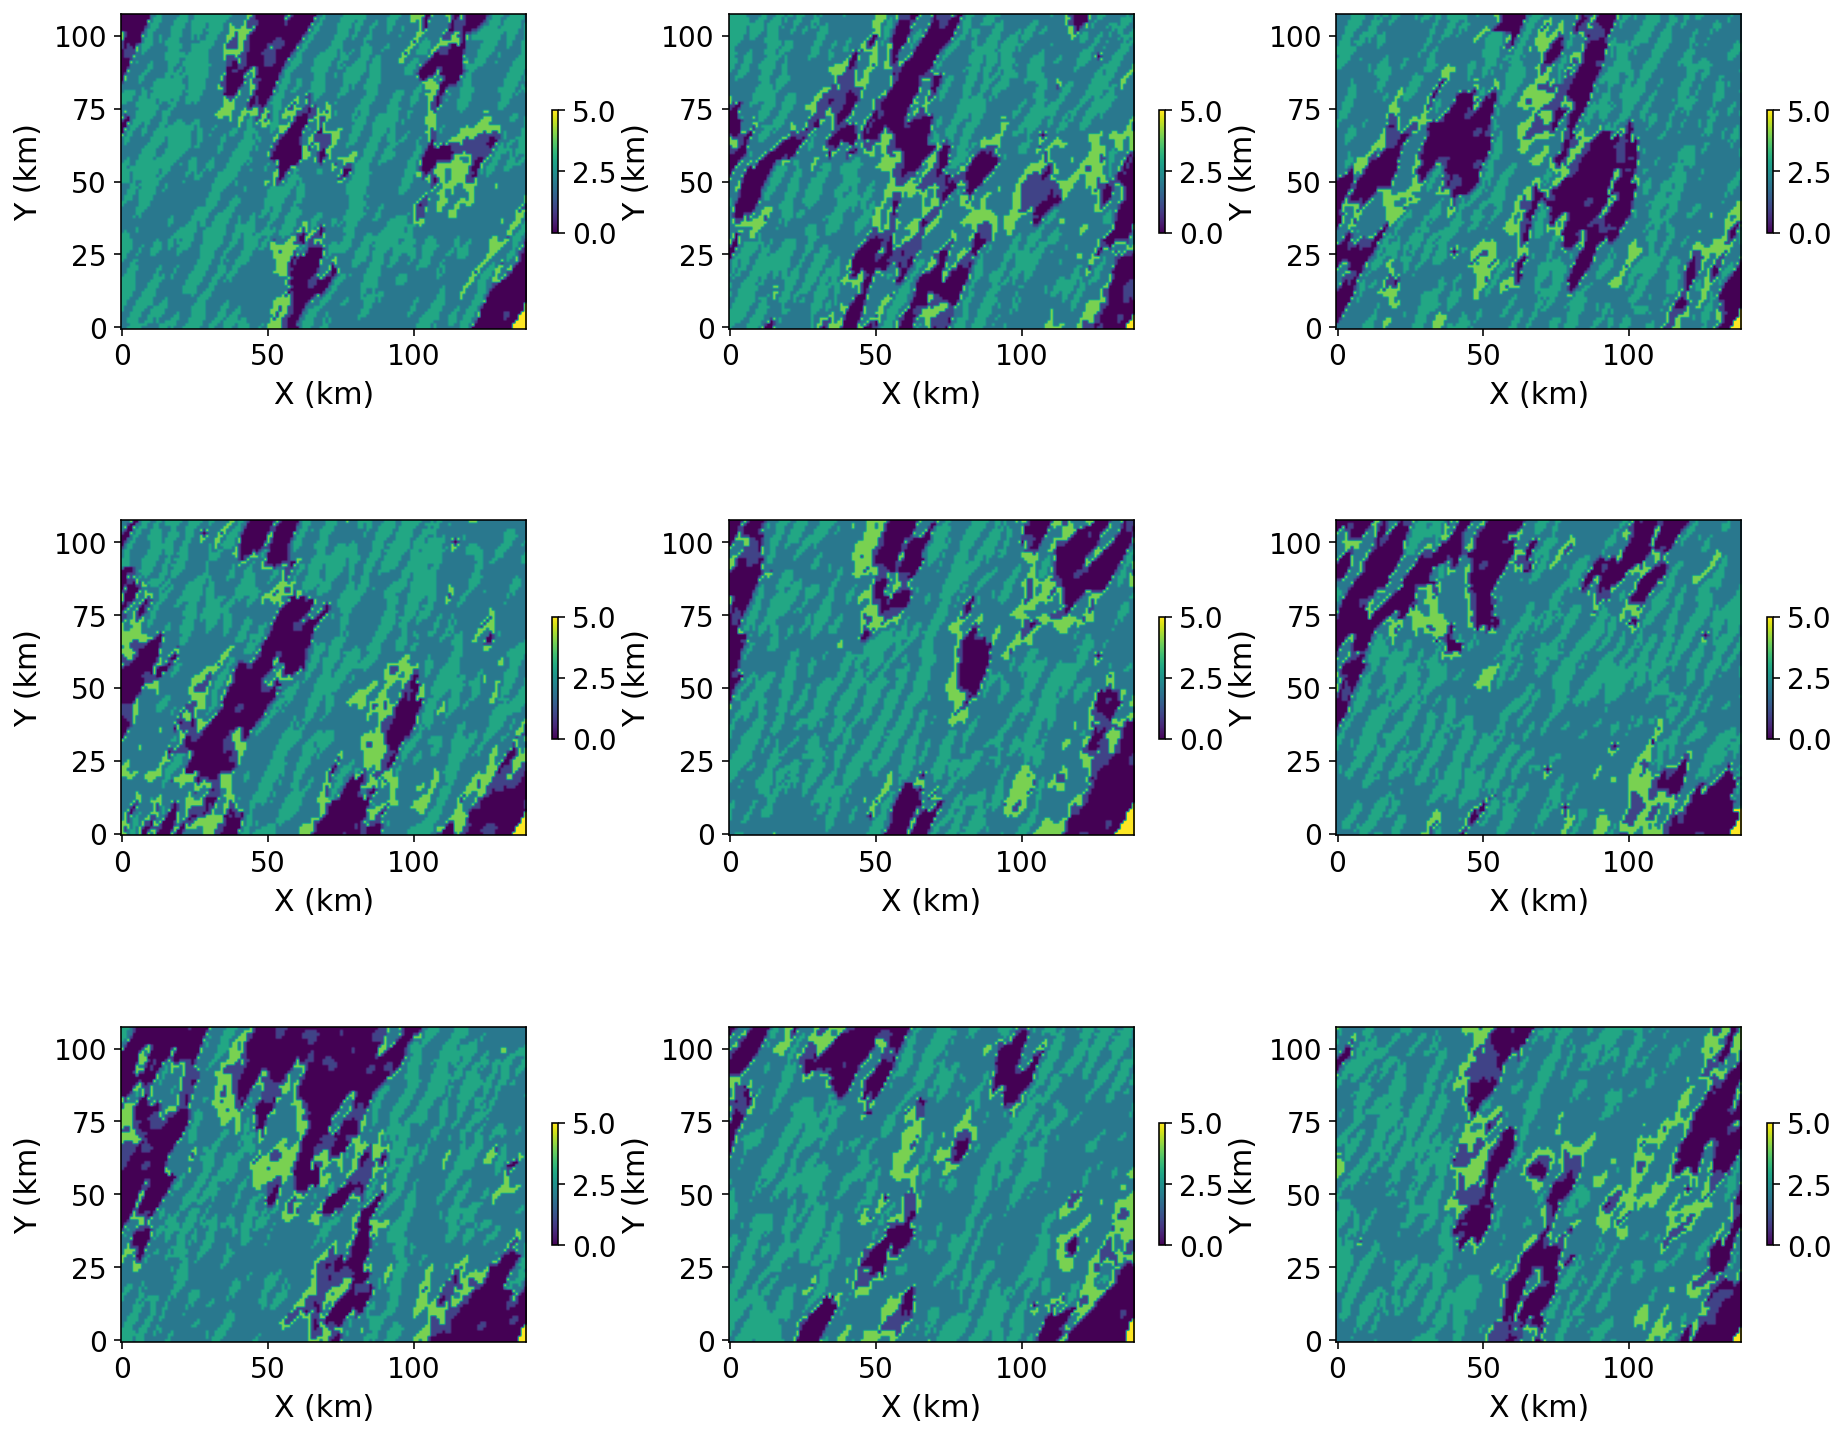

In [113]:
plt.figure(figsize=(13,11))
for i in range(9):
    plt.subplot(3,3, i+1)
    # Load the SGSim models exported from SGeMS. 
    realization = np.loadtxt('sgsim_results/facies_real'+str(i)+'_only_numbers', skiprows=1).reshape(108,139)
    multi_real = plt.imshow(realization, 
               #vmax=0.95, vmin=0.15
               #extent=[0, 169,0, 151 ], 
               origin='lower')
    plt.colorbar(shrink=0.25)
    plt.xlabel('X (km)'), plt.ylabel('Y (km)')
plt.tight_layout()
fig = multi_real.get_figure()
fig.savefig("images/multi_real_facies.png") 

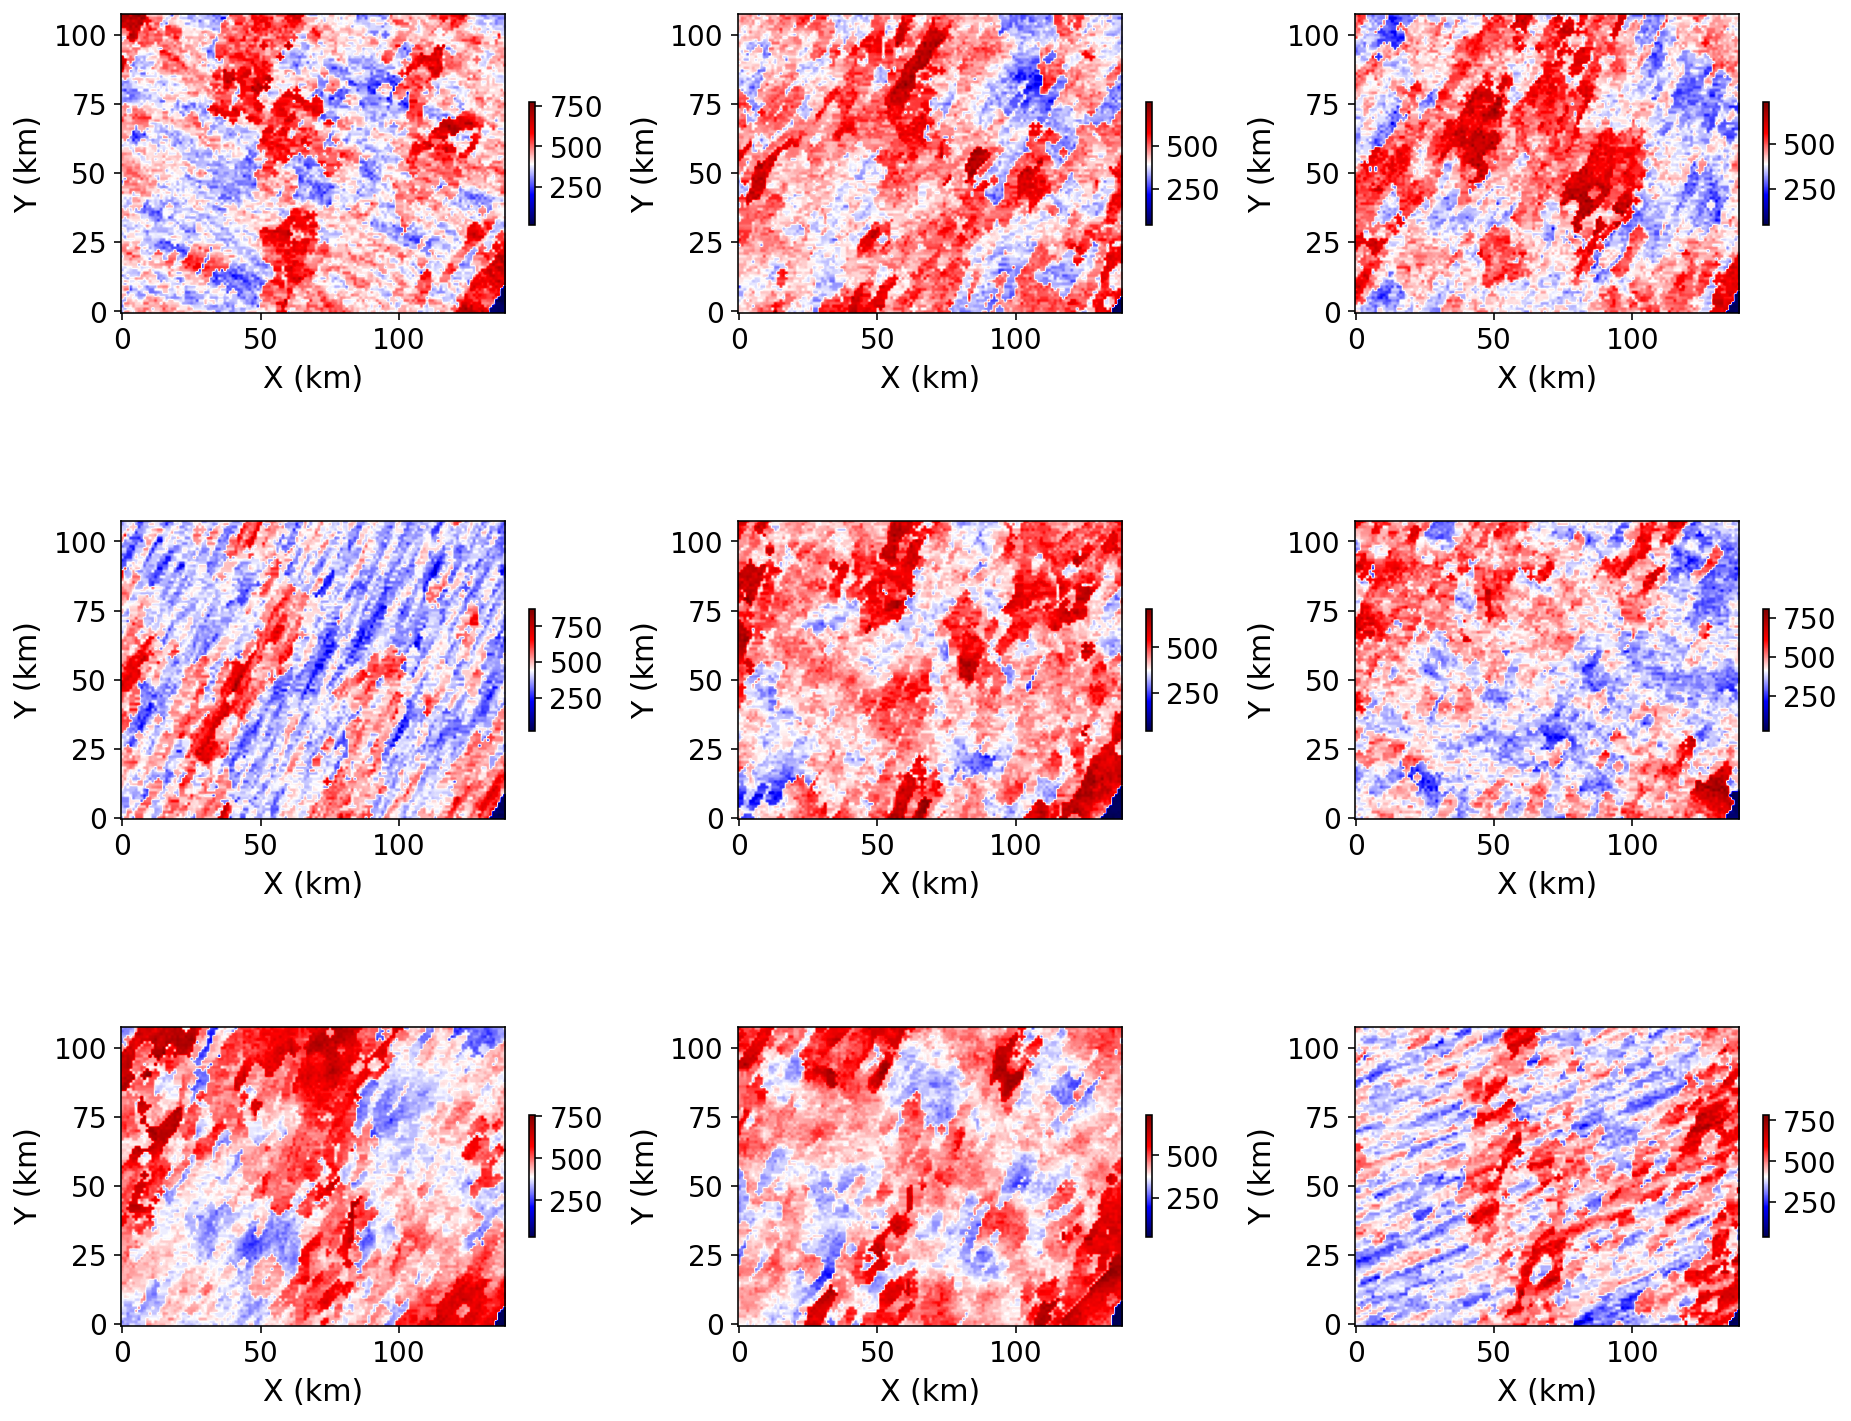

In [20]:
plt.figure(figsize=(13,11))
for i in range(9):
    plt.subplot(3,3, i+1)
    # Load the SGSim models exported from SGeMS. 
    realization = np.loadtxt('sgsim_results/perm_real'+str(i), skiprows=1).reshape(108,139)
    multi_real = plt.imshow(realization, 
               #vmax=0.95, vmin=0.15
               #extent=[0, 169,0, 151 ], 
               cmap = 'seismic',
               origin='lower')
    plt.colorbar(shrink=0.25)
    plt.xlabel('X (km)'), plt.ylabel('Y (km)')
plt.tight_layout()
fig = multi_real.get_figure()
fig.savefig("images/multi_real_perm.png") 

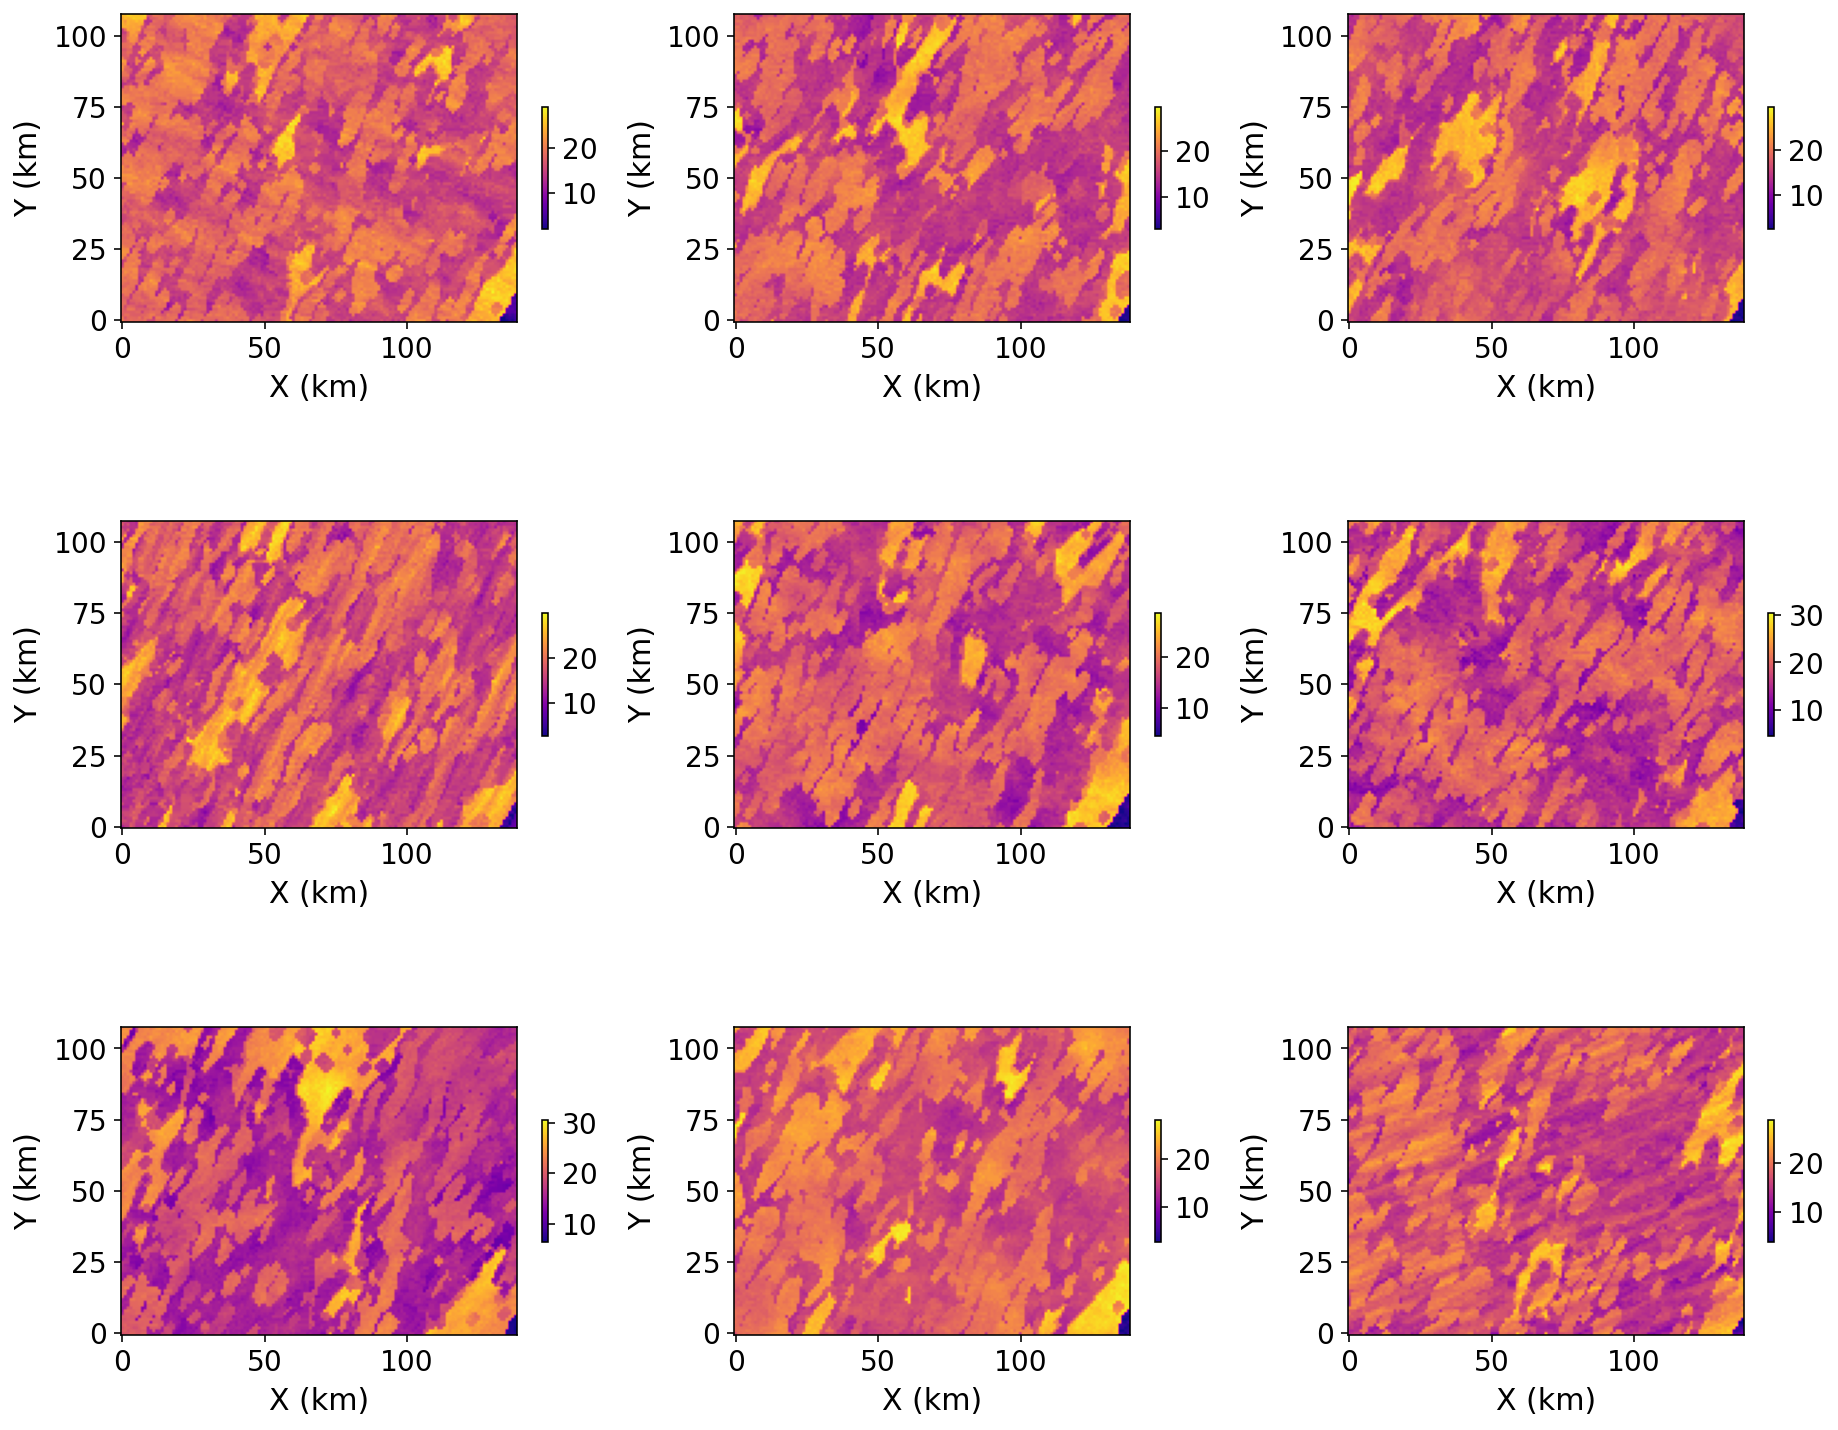

In [111]:
plt.figure(figsize=(13,11))
for i in range(9):
    plt.subplot(3,3, i+1)
    # Load the SGSim models exported from SGeMS. 
    realization = np.loadtxt('sgsim_results/por_real'+str(i), skiprows=1).reshape(108,139)
    multi_real = plt.imshow(realization, cmap = 'plasma',
                            origin='lower')
    plt.colorbar(shrink=0.25)
    plt.xlabel('X (km)'), plt.ylabel('Y (km)')
plt.tight_layout()
fig = multi_real.get_figure()
fig.savefig("images/multi_real_por.png") 

Now, you can run the Monte Carlo simulations with SGeMS on your own dataset/project. 

# Removing header and turning porosity into % values to input in the flow simulator

In [22]:
# erase first line perm files
n_real = 100
for i in range(n_real):
    with open('sgsim_results/perm_real'+str(i),'r') as f:
        with open('sgsim_results/permeability_real'+str(i),'w') as f1:
            next(f) # skip header line
            for line in f:
                f1.write(line)

In [58]:
# erase first line por files
n_real = 100
for i in range(n_real):
    with open('sgsim_results/por_real'+str(i),'r') as f:
        with open('sgsim_results/porosity_real'+str(i),'w') as f1:
            next(f) # skip header line
            for line in f:
                f1.write(line)

In [ ]:
# erase first line por files
n_real = 100
for i in range(n_real):
    realization_temp2 = pd.read_table('sgsim_results/porosity_real'+str(i), header=None)
    realization_temp = realization_temp2/100
    realization = np.around(realization_temp, decimals=5)
    pd.DataFrame(realization).to_csv('sgsim_results/porosity_real'+str(i), header=False, index=False)

# Creating looping to plot bhp vs time

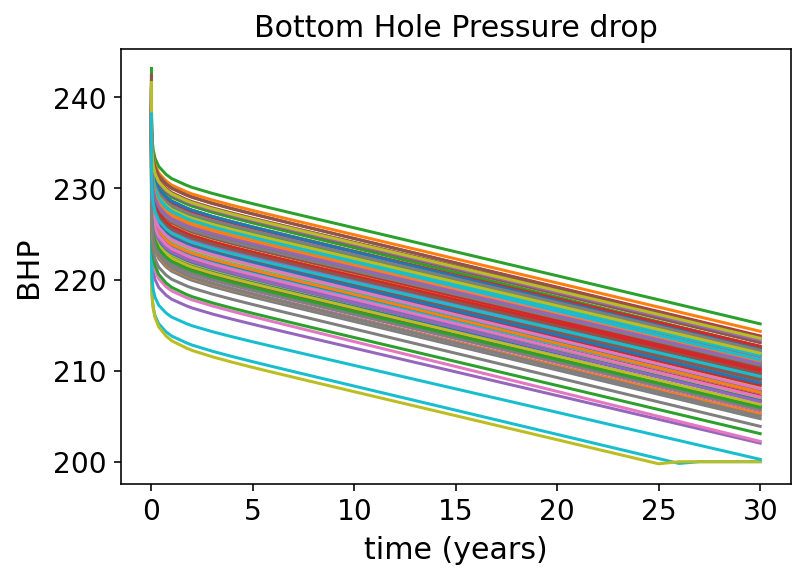

In [13]:
# Plot the density functions on top of each other.
n_real = 100
for i in range(n_real):
    reals = pd.read_table('flow_results/Real_'+str(i)+'.rates.txt', delim_whitespace=True)
    graph_bhpxtime = sns.lineplot(x=reals['Day']/365, y=reals['W2:BHP'])
    # Plot formatting
    plt.title('Bottom Hole Pressure drop')
    plt.xlabel('time (years)')
    plt.ylabel('BHP')
fig = graph_bhpxtime.get_figure()
fig.savefig("images/bhp_x_time.png") 

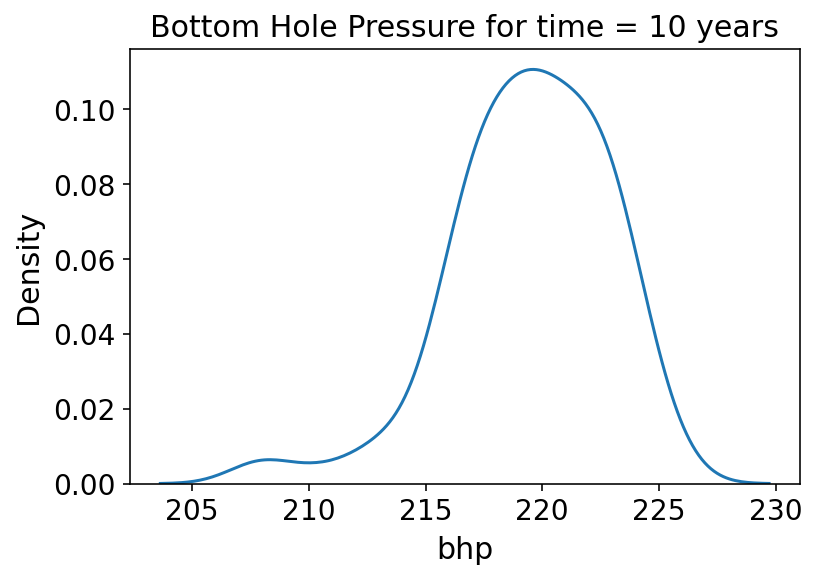

In [14]:
# Plot the pdf functions for bhp in time = 10 years.
n_real = 100
bhp_pts = []
for i in range(n_real):
    reals = pd.read_table('flow_results/Real_'+str(i)+'.rates.txt', delim_whitespace=True)
    bhp_pts.append(reals['W2:BHP'][28]) 

graph_bhp10yrs = sns.kdeplot(bhp_pts)
plt.title('Bottom Hole Pressure for time = 10 years')
plt.xlabel('bhp')
plt.ylabel('Density')
fig = graph_bhp10yrs.get_figure()
fig.savefig("images/bhp_10yrs.png") 


# Creating looping to plot bhp vs time with injector well

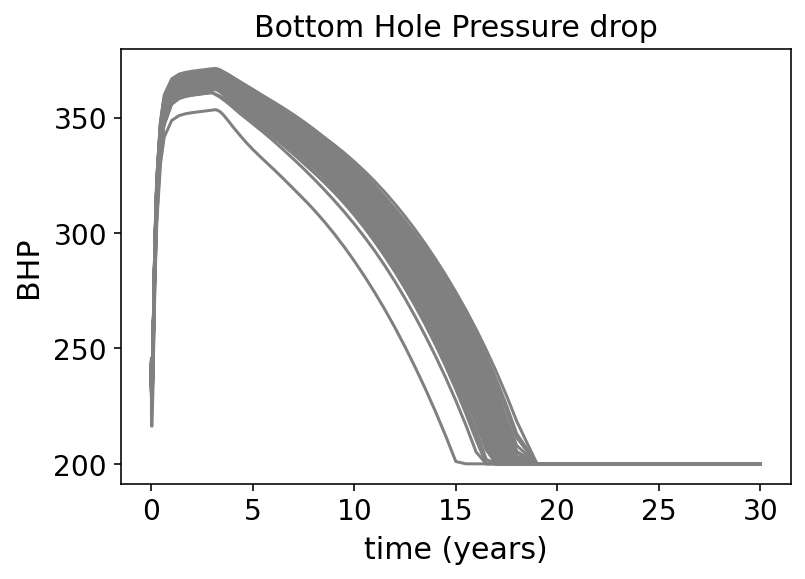

In [2]:
# Plot the density functions on top of each other.
n_real = 100
for i in range(n_real):
    reals = pd.read_table('flow_results_with_injector/QFS_'+str(i)+'.rates.txt', delim_whitespace=True)
    graph_bhpxtime = sns.lineplot(x=reals['Day']/365, y=reals['W2:BHP'], color='grey')
    # Plot formatting
    plt.title('Bottom Hole Pressure drop')
    plt.xlabel('time (years)')
    plt.ylabel('BHP')

#reals = pd.read_table('flow_results_with_injector/QFS_100.rates.txt', delim_whitespace=True)
#graph_bhpxtime = sns.lineplot(x=reals['Day']/365, y=reals['W2:BHP'], color='red')

fig = graph_bhpxtime.get_figure()
fig.savefig("images/bhp_x_time_with_injector_sim_only.png") 

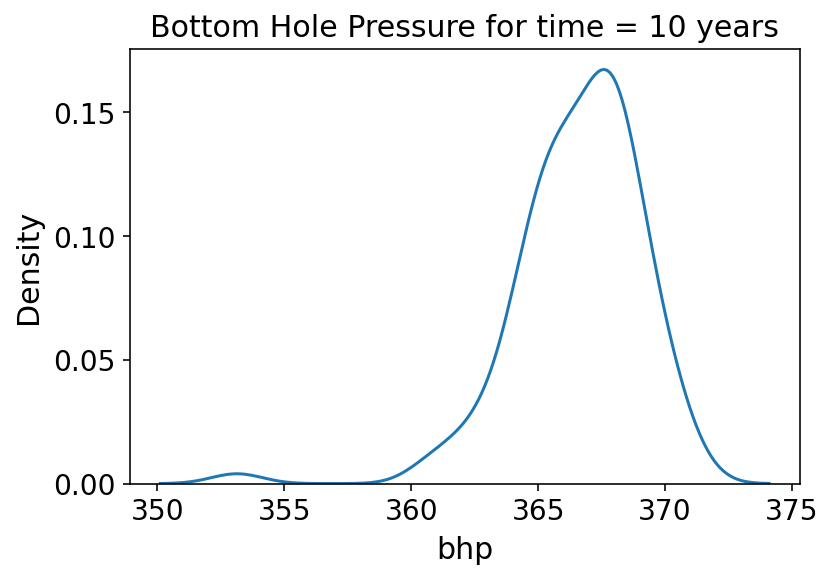

In [69]:
# Plot the pdf functions for bhp in time = 10 years.
n_real = 100
bhp_pts = []
for i in range(n_real):
    reals = pd.read_table('flow_results_with_injector/QFS_'+str(i)+'.rates.txt', delim_whitespace=True)
    bhp_pts.append(reals['W2:BHP'][28]) 

graph_bhp10yrs = sns.kdeplot(bhp_pts)
plt.title('Bottom Hole Pressure for time = 10 years')
plt.xlabel('bhp')
plt.ylabel('Density')
fig = graph_bhp10yrs.get_figure()
fig.savefig("images/bhp_10yrs_with_injector.png") 

# Creating robust Mahalanob distance RMD function

In [22]:
def RobustMD_flsification(d_var, d_obs, prior_name, plt_OrNot, Q_quantile):
    
    '''
    This function falsifies the prior using Robust Mahalanobis Distance RMD.  
    d_var: the data variable, (nXp)
    d_obs: the data observation variable, (1xp)
    prior_name: name of the prior model for falsification, string
    plt_OrNot: True or False, to create the distribution plot of the calculated RMDs. 
    Q_quantile：the Q_quantile of the RMD distribution, 95 or 97.5 is suggested
    example: MD_flsification(d_pri, d_obs, True, 95) will produce the RMD_obs, RMD_pri, RMD_Q95, and plot them. 
    '''
    
    mcd = MCD(random_state=0).fit(d_var)
    new_obs = d_obs-mcd.location_
    md_obs= np.sqrt(new_obs.dot(np.linalg.inv(mcd.covariance_)).dot(new_obs.T))
    print('Robust Mahalanobis Distance of d_obs = ', md_obs[0,0].round(decimals = 3))
    md_samples=[]
    for i in range(len(d_var)):
        sample = d_var[i:i+1, :]-mcd.location_
        md_samp = np.sqrt(sample.dot(np.linalg.inv(mcd.covariance_)).dot(sample.T))[0,0]
        md_samples.append(md_samp)
    md_samples = np.asarray(md_samples)
    print(str(Q_quantile)+'th Quantile of Robust Mahalanobis Distance is', \
          stats.scoreatpercentile(md_samples, Q_quantile).round(decimals=3))

    if plt_OrNot == True:
        plt.figure(figsize=(6,5))
        plt.scatter(np.arange(1,(len(d_var)+1)), md_samples, c=abs(md_samples),                     cmap ='winter_r', s=50, vmax = md_samples.max(), vmin=md_samples.min(),                    linewidths=1, edgecolor='k')
        plt.scatter([0], md_obs, c=md_obs,                     cmap ='winter_r', marker='D', s=110, vmax = md_samples.max(), vmin=md_samples.min(),                    linewidths=3, edgecolor='red')
        plt.ylabel('Robust Mahalanobis dist', fontsize=12)
        plt.xlabel('realization No.', fontsize=12)
        plt.xlim(-8, 259)
        plt.hlines(y=stats.scoreatpercentile(md_samples, Q_quantile), xmin= -10, xmax=259, colors='red', linewidths=2, linestyles='--')
        cbar = plt.colorbar(fraction=0.035)
        cbar.ax.set_ylabel('RMD')
        plt.title('Prior falsification of "'+ prior_name+'" using Robust Mahalanobis Distance', \
                  fontsize=18, loc='left', style='italic')
    
    return md_obs[0,0].round(decimals = 3), stats.scoreatpercentile(md_samples, Q_quantile).round(decimals=3)

In [34]:
n_real = 100
df_d_var = pd.DataFrame()
for i in range(n_real):
    reals = pd.read_table('flow_results_with_injector/QFS_'+str(i)+'.rates.txt', delim_whitespace=True)
    W2_BHP = reals['W2:BHP'][:70] 
    df_d_var['W2_BHP_'+str(i)+'_real'] = W2_BHP.tolist()

In [58]:
d_var = df_d_var.to_numpy()
d_var = d_var.T
print(d_var.shape)


(100, 70)


In [36]:
df_d_obs = pd.DataFrame()
reals = pd.read_table('flow_results_with_injector/QFS_100.rates.txt', delim_whitespace=True)
W2_BHP = reals['W2:BHP'][:70]
df_d_obs['W2_BHP_100_real'] = W2_BHP.tolist()

In [62]:
d_obs = df_d_obs.to_numpy()
d_obs = d_obs.T
print(d_obs)

[[244.638 243.266 241.906 240.711 239.671 238.704 237.756 236.818 235.885
  234.907 233.806 232.634 232.377 233.766 240.848 250.278 270.65  289.23
  316.044 334.19  351.859 362.849 364.892 367.039 367.873 368.37  368.762
  369.117 369.323 369.526 369.555 367.864 366.566 365.318 364.193 363.231
  361.453 361.148 358.662 355.199 351.868 348.603 345.383 342.096 338.603
  334.759 330.477 325.753 320.655 315.276 309.674 303.843 297.732 291.248
  284.274 276.707 268.493 259.633 250.136 240.029 217.756 200.    200.
  200.    200.    200.    200.    200.    200.    200.   ]]


In [61]:
prior_name = 'Prior_Name'
RobustMD_flsification(d_var, d_obs, prior_name, True, 95)

C:\Anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


LinAlgError: Singular matrix

# Creating water and oil rates x time

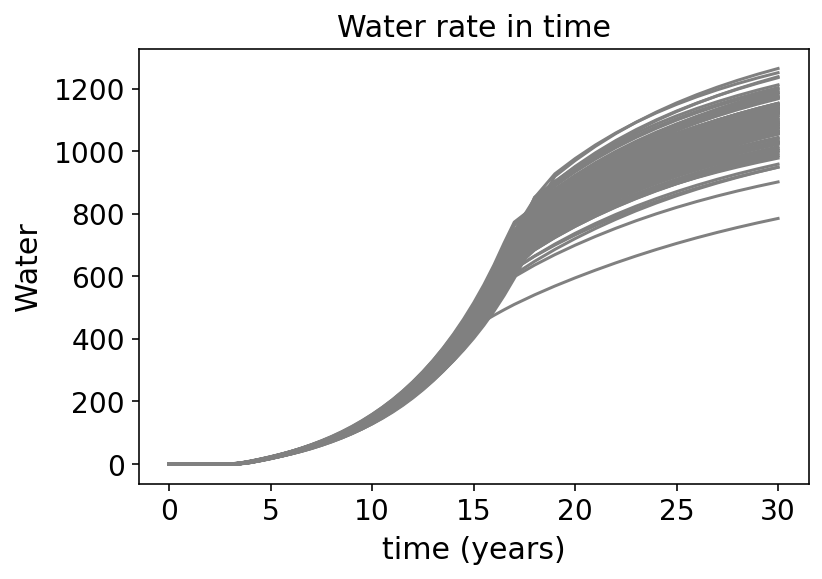

In [5]:
# Plot the density functions on top of each other.
n_real = 100
for i in range(n_real):
    reals = pd.read_table('flow_results_with_injector/QFS_'+str(i)+'.rates.txt', delim_whitespace=True)
    graph_bhpxtime = sns.lineplot(x=reals['Day']/365, y=reals['W2:WAT'], color='grey')
    # Plot formatting
    plt.title('Water rate in time')
    plt.xlabel('time (years)')
    plt.ylabel('Water')

#reals = pd.read_table('flow_results_with_injector/QFS_100.rates.txt', delim_whitespace=True)
#graph_bhpxtime = sns.lineplot(x=reals['Day']/365, y=reals['W2:WAT'], color='red')

fig = graph_bhpxtime.get_figure()
fig.savefig("images/wat_x_time_with_injector_sim_only.png") 

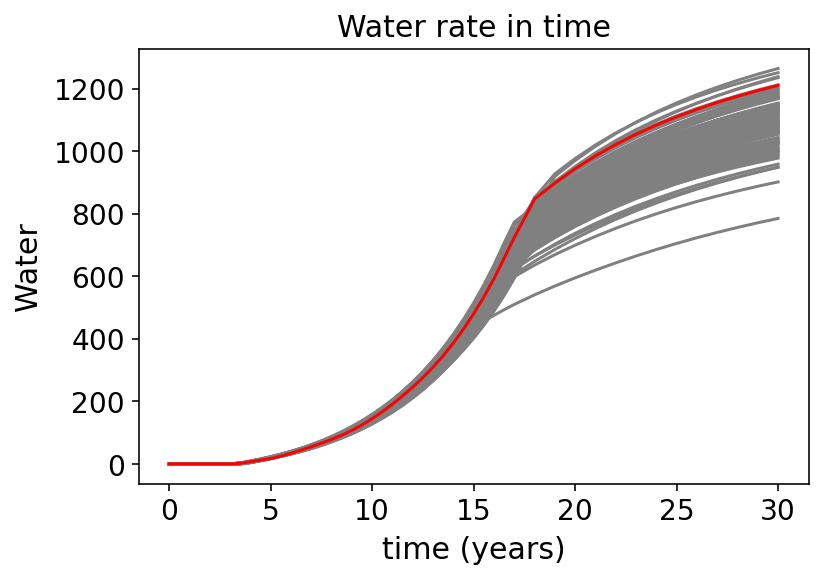

In [7]:
# Plot the density functions on top of each other.
n_real = 100
for i in range(n_real):
    reals = pd.read_table('flow_results_with_injector/QFS_'+str(i)+'.rates.txt', delim_whitespace=True)
    graph_bhpxtime = sns.lineplot(x=reals['Day']/365, y=reals['W2:WAT'], color='grey')
    # Plot formatting
    plt.title('Water rate in time')
    plt.xlabel('time (years)')
    plt.ylabel('Water')

reals = pd.read_table('flow_results_with_injector/QFS_100.rates.txt', delim_whitespace=True)
graph_bhpxtime = sns.lineplot(x=reals['Day']/365, y=reals['W2:WAT'], color='red')

fig = graph_bhpxtime.get_figure()
fig.savefig("images/wat_x_time_with_injector.png") 

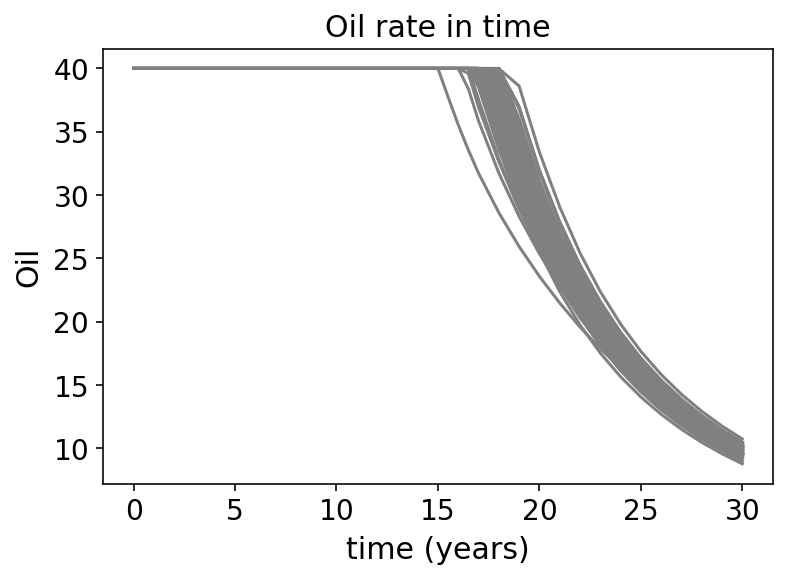

In [6]:
# Plot the density functions on top of each other.
n_real = 100
for i in range(n_real):
    reals = pd.read_table('flow_results_with_injector/QFS_'+str(i)+'.rates.txt', delim_whitespace=True)
    graph_bhpxtime = sns.lineplot(x=reals['Day']/365, y=reals['W2:OIL'], color='grey')
    # Plot formatting
    plt.title('Oil rate in time')
    plt.xlabel('time (years)')
    plt.ylabel('Oil')

#reals = pd.read_table('flow_results_with_injector/QFS_100.rates.txt', delim_whitespace=True)
#graph_bhpxtime = sns.lineplot(x=reals['Day']/365, y=reals['W2:WAT'], color='red')

fig = graph_bhpxtime.get_figure()
fig.savefig("images/oil_x_time_with_injector_sim_only.png") 

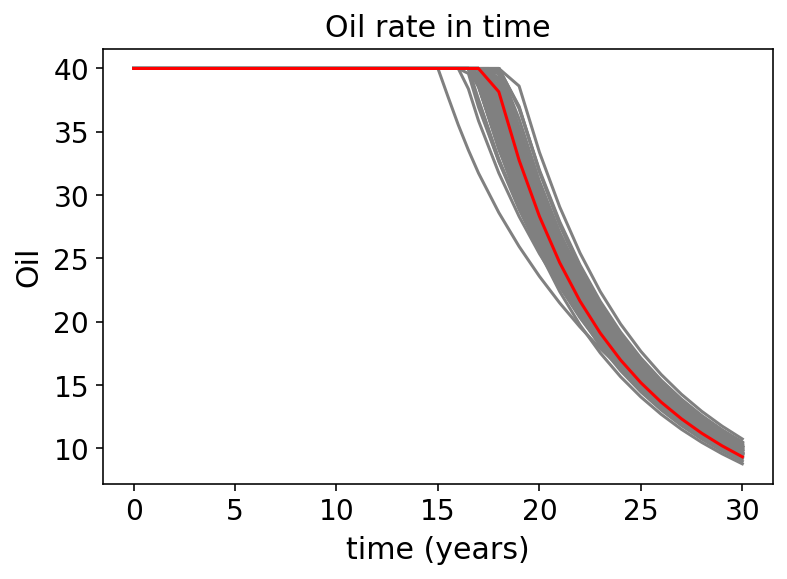

In [8]:
# Plot the density functions on top of each other.
n_real = 100
for i in range(n_real):
    reals = pd.read_table('flow_results_with_injector/QFS_'+str(i)+'.rates.txt', delim_whitespace=True)
    graph_bhpxtime = sns.lineplot(x=reals['Day']/365, y=reals['W2:OIL'], color='grey')
    # Plot formatting
    plt.title('Oil rate in time')
    plt.xlabel('time (years)')
    plt.ylabel('Oil')

reals = pd.read_table('flow_results_with_injector/QFS_100.rates.txt', delim_whitespace=True)
graph_bhpxtime = sns.lineplot(x=reals['Day']/365, y=reals['W2:OIL'], color='red')

fig = graph_bhpxtime.get_figure()
fig.savefig("images/oil_x_time_with_injector.png") 